In [1191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [1192]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [1193]:
data = pd.read_csv('train.csv')

Сразу удаляем технические параметры

In [1194]:
data.drop(['timestamp', 'id'], axis = 1, inplace = True)

Посмотрим какие типы данных и сколько пропущенных значений в датасете

In [1195]:
numeric_variable_columns = data.select_dtypes(include = ['int64', 'float64']).columns

In [1196]:
numeric_variable_missed = data[numeric_variable_columns].isna().sum().sort_values(ascending = True)
numeric_variable_missed[numeric_variable_missed>0]

ID_railroad_station_walk                    25
railroad_station_walk_min                   25
railroad_station_walk_km                    25
metro_km_walk                               25
metro_min_walk                              25
floor                                      167
prom_part_5000                             178
cafe_sum_5000_max_price_avg                297
cafe_avg_price_5000                        297
cafe_sum_5000_min_price_avg                297
cafe_sum_3000_min_price_avg                991
cafe_sum_3000_max_price_avg                991
cafe_avg_price_3000                        991
cafe_sum_2000_min_price_avg               1725
cafe_sum_2000_max_price_avg               1725
cafe_avg_price_2000                       1725
cafe_sum_1500_max_price_avg               4199
cafe_sum_1500_min_price_avg               4199
cafe_avg_price_1500                       4199
build_count_1971-1995                     4991
build_count_after_1995                    4991
build_count_f

In [1197]:
categorial_variable_columns = data.select_dtypes(include = ['object']).columns

In [1198]:
categorial_variablem_missed = data[categorial_variable_columns].isna().sum().sort_values(ascending = True)

In [1199]:
categorial_variablem_missed[categorial_variablem_missed > 0]

Series([], dtype: int64)

Пропуски данных в большом количестве присутсвуют в количественных переменных, в категориальных пропущенных значений нет.

Посмотрим качество модели на неизмененных данных

In [1200]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [1201]:
#кодируем категориальные признаки и сохраняем, чтобы при необходимости перекодировать обратно
storage_label = {}
for elem in list(categorial_variable_columns):
    data[elem] = le.fit_transform(data[elem])
    storage_label.update({elem: le.classes_})

In [1202]:
def get_score(X,y, random_seed = 42):
    model =  LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_seed)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [1203]:
score = []

In [1204]:
#исходные данные, перекодированные категориальные переменные
sc1 = get_score(data.dropna().drop('price_doc', axis = 1), data.dropna()['price_doc'])
print(sc)
score.append(sc1)

0.47825541423237106


Заполним пропуски. Пропуски в данных, содержащие средние значения (cafe_sum_500_max_price_avg и так далее) заполним средними же значениями.

In [1205]:
def get_value(X, column, mode='mean', value=0): 
    if mode == 'value':
        X.loc[X[X[column].isna()].index ,column] = value 
    elif mode == 'max':
        X.loc[X[X[column].isna()].index ,column] = X[column].max() 
    elif mode == 'min':
        X.loc[X[X[column].isna()].index ,column] = X[column].min()  
    elif mode == 'median':
        X.loc[X[X[column].isna()].index ,column] = X[column].median()  
    elif mode == 'mode':
        X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]  
    elif mode == 'indicator': 
        X['ind_'+str(column)] = 0
        X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
        X.loc[X[X[column].isna()].index, column] = 0     
    else:
        X.loc[X[X[column].isna()].index, column] = X[column].mean() 
    return X.head(3)

In [1206]:
import re

Различные параметры средних с пропущенными значениями заполним теми же средними

In [1207]:
avg_list = []
for elem in list(numeric_variable_columns):
    if len(re.findall('_avg', elem)) > 0:
        avg_list.append(elem)

for elem in avg_list:
    get_value(data, elem)

Таким же способом можно заполнить время ходьбы до метро, квоты на школу и площади

In [1254]:
walk_list = []
for elem in list(numeric_variable_columns):
    if len(re.findall('_walk', elem)) > 0:
        walk_list.append(elem)
        
for elem in walk_list:
    get_value(data, elem)

In [1209]:
quota_list = []
for elem in list(numeric_variable_columns):
    if len(re.findall('_quota', elem)) > 0:
        quota_list.append(elem)
        
for elem in quota_list:
    get_value(data, elem)

In [1210]:
sq_list = []
for elem in list(numeric_variable_columns):
    if len(re.findall('_sq', elem)) > 0:
        sq_list.append(elem)

for elem in sq_list:
    get_value(data, elem)

In [1211]:
sc2 = get_score(data.dropna().drop('price_doc', axis =1), data.dropna()['price_doc'])
print(sc2)
score.append(sc2)

0.5920737960124374


Заполнение пустых значений привело к существенному увеличению score модели с 0.47 до 0.59.

Различные параметры постройки логичнее всего заполнить модой

In [1212]:
build_list = []
for elem in list(numeric_variable_columns):
    if len(re.findall('build_', elem)) > 0:
        build_list.append(elem)

for elem in build_list:
    get_value(data, elem, mode = 'mode')

In [1213]:
sc3 = get_score(data.dropna().drop('price_doc', axis =1), data.dropna()['price_doc'])
print(sc3)
score.append(sc3)

0.5684986598803409


Точность модели чуть упала, но не сильно, следовательно способ заполнения был выбран корректно.

In [1214]:
#проверим что осталось заполнить
numeric_variable_missed = data[numeric_variable_columns].isna().sum().sort_values(ascending = True)
numeric_variable_missed[numeric_variable_missed>0]

floor                    167
prom_part_5000           178
num_room                9572
material                9572
max_floor               9572
state                  13559
hospital_beds_raion    14441
dtype: int64

Параметры state (состояние апартаментов) и hospital_beds_raion имеют больше всего пропусков, заполнение различными методами приводило к резкому уменьшению качества модели. В таком случае, логичнее всего исключить их из модели.

In [1215]:
data.drop(['state', 'hospital_beds_raion'], axis = 1, inplace = True)

In [1216]:
sc4 = get_score(data.dropna().drop('price_doc', axis =1), data.dropna()['price_doc'])
print(sc4)
score.append(sc4)

0.577165033713956


Точность модели чуть возрасла

In [1218]:
#проверим что осталось заполнить
numeric_variable_missed_ = data[numeric_variable_columns_].isna().sum().sort_values(ascending = True)
numeric_variable_missed_[numeric_variable_missed_>0]

floor              167
prom_part_5000     178
num_room          9572
material          9572
max_floor         9572
dtype: int64

Параметр num_room и material лучше всего заполнить медианой

In [1219]:
get_value(data, 'num_room', mode = 'median')
get_value(data, 'material', mode = 'median')

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,product_type,sub_area,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43.0,27.0,4.0,NaN,1.0,2014.0,2.0,6.399301,0,9,...,9,4,0,13,22,1,0,52,4,5850000
1,34.0,19.0,3.0,NaN,1.0,2014.0,2.0,6.399301,0,70,...,15,3,0,15,29,1,10,66,14,6000000
2,43.0,29.0,2.0,NaN,1.0,2014.0,2.0,6.399301,0,129,...,10,3,0,11,27,0,4,67,10,5700000


In [1220]:
sc5 = get_score(data.dropna().drop('price_doc', axis = 1), data.dropna()['price_doc'])
print(sc5)
score.append(sc5)

0.577165033713956


In [1221]:
#проверим что осталось заполнить
numeric_variable_missed_ = data[numeric_variable_columns_].isna().sum().sort_values(ascending = True)
numeric_variable_missed_[numeric_variable_missed_>0]

floor              167
prom_part_5000     178
max_floor         9572
dtype: int64

Разберем отдельно параметр max_floor

<AxesSubplot:xlabel='max_floor'>

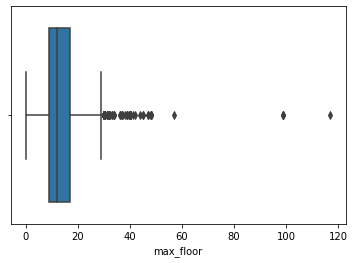

In [1222]:
sns.boxplot(data['max_floor'])

В Москве явно нет 100 и 120 этажных домов, исключим выбросы.

In [1223]:
data.drop(index = list(data.index[data['max_floor'] > 55]), inplace = True)

In [1224]:
sc6 = get_score(data.dropna().drop('price_doc', axis =1), data.dropna()['price_doc'])
print(sc6)
score.append(sc6)

0.5952444725019064


Точность модели стала даже больше чем после заполнения первых признаков 

In [1225]:
#проверим что осталось заполнить
numeric_variable_missed_ = data[numeric_variable_columns_].isna().sum().sort_values(ascending = True)
numeric_variable_missed_[numeric_variable_missed_>0]

floor              167
prom_part_5000     178
max_floor         9572
dtype: int64

Параметр max_floor имеет больше всего пропущенных значений, при анализе оказывается что год постройки этих домой был 2014

In [1226]:
data[['build_year', 'max_floor']]

,build_year,max_floor
0,2014.0,NaN
1,2014.0,NaN
2,2014.0,NaN
3,2014.0,NaN
4,2014.0,NaN
...,...,...
30466,1975.0,9.0
30467,1935.0,9.0
30468,2014.0,20.0
30469,2003.0,15.0


In [1227]:
data.loc[(d['max_floor'].isna()) & (data['build_year'] != 2014)][['build_year', 'max_floor']]

,build_year,max_floor


Попробум разные способы заполнения

In [1228]:
mode_list = ['mean', 'max', 'min', 'median', 'mode']
for elem in mode_list:
    d = data.copy()
    get_value(d, 'max_floor', mode = elem)
    print(elem, get_score(d.dropna().drop('price_doc', axis =1), d.dropna()['price_doc']))

mean -0.8634748524813407
max -0.8457493221334436
min -0.8023406436109548
median -0.8599071379165582
mode -0.8820340546838976


In [1229]:
for i in range(5,30):
    d = data.copy()
    get_value(d, 'max_floor', mode = 'value', value = i)
    print(i, get_score(d.dropna().drop('price_doc', axis =1), d.dropna()['price_doc']))

5 -0.8156102658205797
6 -0.8202505008823093
7 -0.8256570979831321
8 -0.8317872887148554
9 -0.8385211088961604
10 -0.8456518207460793
11 -0.8528930397162431
12 -0.8599071379165582
13 -0.8663518853797461
14 -0.8719334998097155
15 -0.8764498304057347
16 -0.8798109523776547
17 -0.8820340546838976
18 -0.8832191434576557
19 -0.8835166640819248
20 -0.8830969709776395
21 -0.8821273388951185
22 -0.8807576856664965
23 -0.8791143657968088
24 -0.8772986374478939
25 -0.8753886944751055
26 -0.8734429351840387
27 -0.8715036385278927
28 -0.8696004220302029
29 -0.8677532308944067


Во всех случаях результат был хуже, несмотря на то что эти данные занимают почти 30% вероятнее всего лучше будет их просто исключить. Таким образом, после пропусков получаем следующий результат:

In [1132]:
get_score(data.dropna().drop('price_doc', axis =1), data.dropna()['price_doc'])

0.5952444725019064

In [1238]:
x = [x+1 for x in range(len(score))]

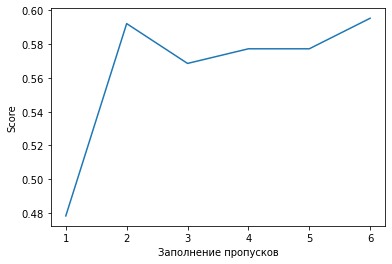

In [1247]:
sns.lineplot(x, score)
plt.xlabel('Заполнение пропусков')
plt.ylabel('Score')
plt.show()

### Генерация новых признаков

In [1348]:
dd = data.dropna().copy()

In [1349]:
score2= []

Объединим все средние значения признаков связанных с кафе в один общий

In [1312]:
dd['cafe_avg_'] = (dd['cafe_avg_price_500'] + dd['cafe_avg_price_1000'] + dd['cafe_avg_price_1500'] \
                    + dd['cafe_avg_price_2000'] + dd['cafe_avg_price_3000'] + dd['cafe_avg_price_5000'])/6

In [1350]:
sc2_1 = get_score(dd.dropna().drop('price_doc', axis =1), dd.dropna()['price_doc'])
print(sc2_1)
score2.append(sc2_1)

0.5952444725019064


Средняя скорость ходьбы до метро (км в мин)

In [1351]:
dd['walk_to_metro'] = dd['metro_km_walk']/dd['metro_min_walk']

In [1352]:
sc2_2 = get_score(dd.dropna().drop('price_doc', axis =1), dd.dropna()['price_doc'])
print(sc2_2)
score2.append(sc2_2)

0.5552621063704847


Прологарифмируем полную площадь жилища

In [1353]:
dd.drop(index = list(dd.index[dd['full_sq'] == 0]), inplace = True)

In [1354]:
dd['full_sq_ln'] = np.log(dd['full_sq'])

In [1355]:
sc2_3 = get_score(dd.dropna().drop('price_doc', axis =1), dd.dropna()['price_doc'])
print(sc2_3)
score2.append(sc2_3)

0.5906526696400403


Количество рабочего населения в долях

In [1322]:
dd['perc_work_people'] = dd['work_all']/(dd['young_all']+dd['ekder_all'])

In [1356]:
sc2_4 = get_score(dd.dropna().drop('price_doc', axis =1), dd.dropna()['price_doc'])
print(sc2_4)
score2.append(sc2_4)

0.5906526696400403


Соотношение религиозных учредждений к нерелигиозным

In [1357]:
dd['perc_rel_to_non_rel'] = (dd['church_count_500'] + dd['church_count_1000'] + dd['church_count_1500'] + dd['church_count_2000'] +\
            dd['church_count_3000'] + dd['church_count_5000'] + dd['mosque_count_500'] + dd['mosque_count_1000'] + \
            dd['mosque_count_1500'] + dd['mosque_count_2000'] + dd['mosque_count_3000'] + dd['mosque_count_5000']) / \
            (dd['leisure_count_500'] + dd['leisure_count_1000'] + dd['leisure_count_1500'] + dd['leisure_count_2000'] + \
            dd['leisure_count_3000'] + dd['leisure_count_5000'] + dd['sport_count_500'] + dd['sport_count_1000'] + \
            dd['sport_count_1500'] + dd['sport_count_2000'] + dd['sport_count_3000'] + dd['sport_count_5000'])

In [1358]:
dd.replace([np.inf, -np.inf], np.nan, inplace = True)

In [1359]:
sc2_5 = get_score(dd.dropna().drop('price_doc', axis =1), dd.dropna()['price_doc'])
print(sc2_5)
score2.append(sc2_5)

0.5777219610392715


In [1362]:
x2 = [x+1 for x in range(len(score2))]

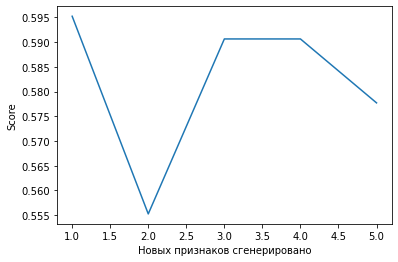

In [1364]:
sns.lineplot(x2, score2)
plt.xlabel('Новых признаков сгенерировано')
plt.ylabel('Score')
plt.show()